# Homework 1: Numpy, Scipy, Pandas

### Due Tues Feb 1, 2022 @ 8pm

### Casey Lam, casey_lam@berkeley.edu

### Collaborators: #hw1-discussion channel


## #0: Get set up with your environment to work on and submit homework

a. Create a new homework repository at github

<img src="data/screenshot_1.png">

Name your repo something sensible (e.g., python-ay250-homeworks). Given your Berkeley affiliation you should be able to get private repos if you'd like.

<img src="data/screenshot_2.png">


b. Clone this repo locally and make a directory for this week's homework:

```bash
cd /class/directories ## this will be different on your machine...whereever you want to keep your work.

# change <username> to your github username:
git clone https://github.com/<username>/python-ay250-homework.git
cd python-ay250-homework
mkdir hw_1
echo "hw_1 README" >> hw_1/README.md
git add hw_1/README.md
git commit hw_1/README.md -m "added hw_1 directory"
git push
```

c. Copy this notebook into your `hw_1` folder from a local version of the python-seminar repo

```bash
cd /class/directories
git clone https://github.com/profjsb/python-seminar.git 
cd python-seminar
git pull
cp -r Homeworks/hw_1/* /class/directories/python-ay250-homework/hw_1/
```

d. Get working! Be sure to check in your work as often as you'd like

```bash
cd /class/directories/python-ay250-homework
git add hw_1/<whatever>
git commit <whatever> -m "this is a check in"
git push
```

e. To submit your work, go to this form to register your homework Repo URL (https://forms.gle/z9XZqCD5Ra9ikTGQ8). If you've made your repo private, you'll need to add us as collaborators to the repo.  Our Github handles are `@profjsb` and `@elliesch`.

## #1:  Super-resolution imaging 

Obtaining several snapshots of the same scene, from microscopes to telescopes, is useful for the postprocessing increase of signal to noise: by summing up imaging data we can effectively beat down the noise. Interestingly, if we image the same scene from different vistas we can also improve the clarity of the combined image. Being able to discern features in a scene from this combination effort is sometimes called super-resolution imaging.

Here, we'll combine about 4 seconds of a shaky video to reveal the statement on a license plate that is not discernable in any one frame.

<img src="Data/im2-1.png">

A tarball of the data is at: https://zenodo.org/record/5889322/files/homework1_data.tgz?download=1 (Zenodo page for the course: https://zenodo.org/record/5889322). This file is also in the read-only directory on `astro.datahub.berkeley.edu`.

```bash
tar -xvzf homework1_data.tgz  # do NOT check this files into git...
```

**Problem 1** Read in each image into a `numpy` array. Resize each frame to be 3 times larger in each axis (ie. 9 times larger images). Using `scipy.signal.fftconvolve` find the offsets of each frame with respect to the first frame. Report those offsets to 2 decimal places. 

   - Hint0: you can use `PIL` to read the images or `matplotlib.pyplot.imread`
```python
from PIL import Image
array = Image.open(fname).convert('L')
```
   - Hint1: you'll need to figure out how to resize a numpy array. Check out PIL.Image.resize...
   - Hint2: you'll want to reverse the second image when doing the convolution: `scipy.signal.fftconvolve(im1, im2[::-1, ::-1])`
   - Hint3: you'll need to figure out how to identify the peak of the fft convolution to find the offsets between images

In [1]:
from PIL import Image
import numpy as np 
import matplotlib.pyplot as plt
from scipy.ndimage import shift
import scipy.signal
import scipy.fft
from matplotlib.colors import LogNorm
import glob
import copy

In [2]:
# Original images are 288 x 288, so resize up by x3.
new_size = (864, 864)

# Load up and resize reference image (first frame).
array_ref = np.array(Image.open('Data/im2-0.png').convert('L').resize(new_size).getdata()).reshape(new_size)

# Crop images to only keep inner 50%. Limit edge effects.
start_idx = int(0.25*new_size[0])
end_idx = int(0.75*new_size[0])

array_ref_crop = copy.deepcopy(array_ref)
array_ref_crop[:start_idx,:] = 0
array_ref_crop[end_idx:,:] = 0
array_ref_crop[:,:start_idx] = 0
array_ref_crop[:,end_idx:] = 0

# Initialize array into which we'll stack the shifted images.
combo = np.zeros(new_size)

# Initialize array into which we'll record the offsets.
x_off = np.zeros(99)
y_off = np.zeros(99)

# Loop through all images to calculate offsets.
for ii in np.arange(99):
    # Load up image, resize, and crop.
    image = 'Data/im2-' + str(ii+1) + '.png'
    array = np.array(Image.open(image).convert('L').resize(new_size).getdata()).reshape((864,864))

    array_crop = copy.deepcopy(array)
    array_crop[:start_idx,:] = 0
    array_crop[end_idx:,:] = 0
    array_crop[:,:start_idx] = 0
    array_crop[:,end_idx:] = 0

    # Use convolution to figure out what the offset is.
    # I have no idea why we need to subtract the autocorrelation... 
    # In my tests below it doesn't seem like a necessary step, but it 
    # doesn't work on the actual images without this step...
    x = scipy.signal.fftconvolve(array_ref_crop, 
                                 array_crop[::-1, ::-1]) 
    y = scipy.signal.fftconvolve(array_crop, array_crop[::-1, ::-1])

    # Find the peak of the convolution.
    mdx = np.unravel_index((x-y).argmax(), (x-y).shape)
    
    # Figure how far off the peak is from the center to get offset.
    x_off[ii] = int(x.shape[0]/2) - mdx[0]
    y_off[ii] = int(x.shape[1]/2) - mdx[1]
    
    # Shift the image to be the same as the first frame and stack.
    array_shifted = shift(array, (-x_off[ii], -y_off[ii]))
    combo += array_shifted

In [3]:
print('Pixel offset from im2-0 (in original scale, before resizing):')
for ii in np.arange(99):
    print(f'im2-{ii+1} to im2-0: ({x_off[ii]/3:.2f}, {y_off[ii]/3:.2f})')

Pixel offset from im2-0 (in original scale, before resizing):
im2-1 to im2-0: (-8.00, 45.33)
im2-2 to im2-0: (-40.67, 2.33)
im2-3 to im2-0: (-59.33, -10.67)
im2-4 to im2-0: (-1.00, -4.00)
im2-5 to im2-0: (-3.00, -11.67)
im2-6 to im2-0: (-46.00, -23.67)
im2-7 to im2-0: (0.33, 40.67)
im2-8 to im2-0: (-22.00, 12.33)
im2-9 to im2-0: (0.67, 27.67)
im2-10 to im2-0: (-34.67, 2.67)
im2-11 to im2-0: (-50.00, 42.33)
im2-12 to im2-0: (-21.33, 8.00)
im2-13 to im2-0: (-74.33, 73.33)
im2-14 to im2-0: (-19.00, 2.67)
im2-15 to im2-0: (-59.33, 6.33)
im2-16 to im2-0: (-40.67, 0.00)
im2-17 to im2-0: (-19.00, 24.33)
im2-18 to im2-0: (-35.67, 32.33)
im2-19 to im2-0: (-14.67, 8.00)
im2-20 to im2-0: (15.67, 27.00)
im2-21 to im2-0: (-27.00, 37.00)
im2-22 to im2-0: (-16.33, 32.67)
im2-23 to im2-0: (-76.33, 70.00)
im2-24 to im2-0: (-37.67, 21.00)
im2-25 to im2-0: (-40.67, 20.67)
im2-26 to im2-0: (-0.33, 55.67)
im2-27 to im2-0: (-15.67, -16.00)
im2-28 to im2-0: (-18.00, -18.67)
im2-29 to im2-0: (-46.33, 0.00)
im

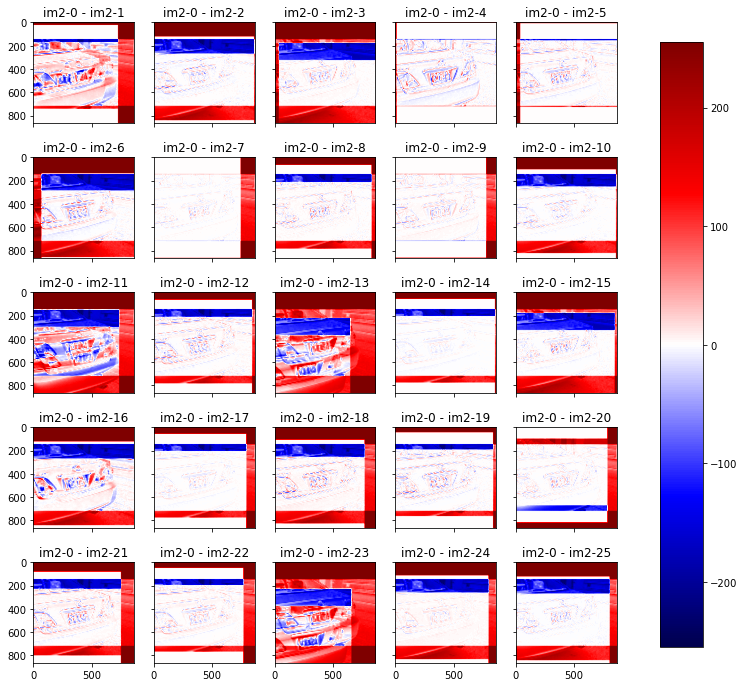

In [4]:
# Caveat to answer above:  the shifting seems to fail for certain frames.
# We inspect the difference between the reference and the first set of 25 frames.
# In about 20% of frames, the shift doesn't seem to have been calculated correctly.
# Not sure if the method I'm using is incorrect, or just that it happens maybe those
# particular images couldn't be matched for some reason. But, it works well enough
# because after stacking, I can read the plate.

fig, axes = plt.subplots(5, 5, sharex='col', sharey='row', figsize=(12,12))

for ii, ax in enumerate(axes.flat):
    # Same code as above used to shift, but istead of stacking, we difference the original and shifted images.
    # If the shift is correct, then the match should be mostly white (i.e. difference = 0).
    image = 'Data/im2-' + str(ii+1) + '.png'
    array = np.array(Image.open(image).convert('L').resize(new_size).getdata()).reshape((864,864))

    array_crop = copy.deepcopy(array)
    array_crop[:start_idx,:] = 0
    array_crop[end_idx:,:] = 0
    array_crop[:,:start_idx] = 0
    array_crop[:,end_idx:] = 0

    x = scipy.signal.fftconvolve(array_ref_crop, 
                                 array_crop[::-1, ::-1]) 
    y = scipy.signal.fftconvolve(array_crop, array_crop[::-1, ::-1])

    mdx = np.unravel_index((x-y).argmax(), (x-y).shape)
    
    x_off = int(x.shape[0]/2) - mdx[0]
    y_off = int(x.shape[1]/2) - mdx[1]
    array_shifted = shift(array, (-x_off, -y_off))
    
    im = ax.imshow(array_ref - array_shifted, vmin = -255,  vmax = 255, cmap='seismic')
    ax.set_title(f'im2-0 - im2-{ii+1}')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)    

**Problem 2** Shift each image to register the frames to the original (expanded in size) frame. You should, in general, be shifting by subpixel offsets. You might want to look at `scipy.ndimage.interpolation.shift`

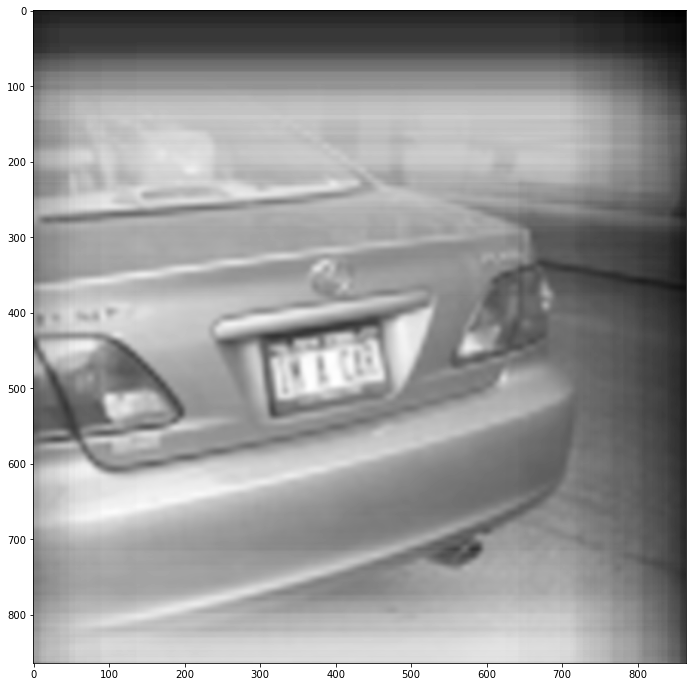

In [5]:
# Code to produce the stack is in Problem 1.
plt.figure(figsize=(12,12))
plt.imshow(combo, cmap='gray')

**Problem 3** Combine all the registered images to form a super-resolution image. What does the license plate read?

**Answer**: IM A CAR

### The stuff below here was just testing the method. 
This is the reason I wasn't sure why subtracting the autocorrelation or even cropping was necessary. Even a huge shift seemed to be recoverable.

In [6]:
# Resize reference image.
array_ref = Image.open('Data/im2-0.png').convert('L')
original_size = array_ref.size
new_size = (3 * original_size[0], 3 * original_size[1])
array_ref_resize = array_ref.resize(new_size)

In [7]:
# Shift reference by a known amount.
npix_shift = (200,300)
array_ref = shift(array_ref_resize, 0)
array_ref_shifted = shift(array_ref_resize, npix_shift)

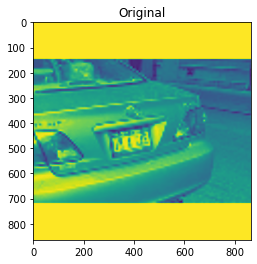

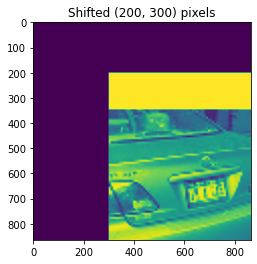

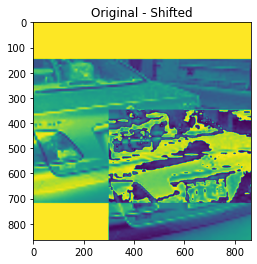

In [8]:
plt.figure(1)
plt.imshow(array_ref)
plt.title('Original')
plt.show()

plt.figure(1)
plt.imshow(array_ref_shifted)
plt.title(f"Shifted {npix_shift} pixels")
plt.show()

plt.figure(1)
plt.imshow(array_ref - array_ref_shifted)
plt.title('Original - Shifted')
plt.show()

In [9]:
# Calculate convolution.
x = scipy.signal.fftconvolve(array_ref, 
                             array_ref_shifted[::-1, ::-1])

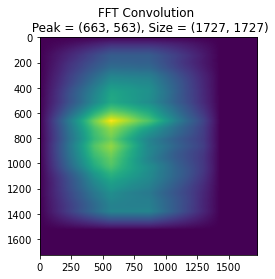

In [10]:
# Find peak pixel.
mdx = np.unravel_index(x.argmax(), x.shape)

plt.title(f'FFT Convolution \n Peak = {mdx}, Size = {x.shape}')
plt.imshow(x-y)

In [11]:
# Calculate offset.
print('Offset in pixels')
print('x offset: ', int(x.shape[0]/2) - mdx[0])
print('y offset: ', int(x.shape[1]/2) - mdx[1])
x_off = int(x.shape[0]/2) - mdx[0]
y_off = int(x.shape[1]/2) - mdx[1]

Offset in pixels
x offset:  200
y offset:  300


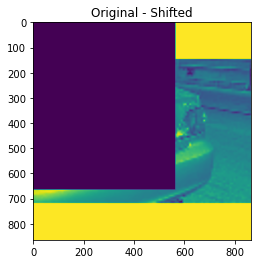

In [12]:
plt.figure(1)
plt.imshow(array_ref - shift(array_ref_shifted, (-x_off, -y_off)))
plt.title('Original - Shifted')
plt.show()

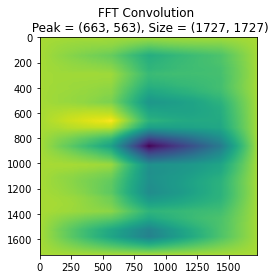

In [13]:
# Same as above, but now subtracting off the autocorrelation. 
# It gives the same thing as before.
y = scipy.signal.fftconvolve(array_ref, array_ref[::-1, ::-1])

mdx = np.unravel_index((x-y).argmax(), (x-y).shape)

plt.title(f'FFT Convolution \n Peak = {mdx}, Size = {x.shape}')
plt.imshow(x-y)

In [14]:
# Calculate offset.
print('Offset in pixels')
print('x offset: ', int(x.shape[0]/2) - mdx[0])
print('y offset: ', int(x.shape[1]/2) - mdx[1])
x_off = int(x.shape[0]/2) - mdx[0]
y_off = int(x.shape[1]/2) - mdx[1]

Offset in pixels
x offset:  200
y offset:  300


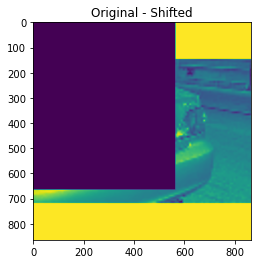

In [15]:
plt.figure(1)
plt.imshow(array_ref - shift(array_ref_shifted, (-x_off, -y_off)))
plt.title('Original - Shifted')
plt.show()

# #2: An elementary introduction to spectral audio compression

In this problem, we'll explore the very basics of audio compression in the spectral domain using numpy and scipy. We'll do a bit of visualization with matplotlib, but since that is covered later in the course, we'll provide those functions for you.

Audio compression is a large and complex topic, and the design of a format for compressed audio such as the popular [MP3](http://en.wikipedia.org/wiki/MP3) is too complex to cover in detail here. However, we will introduce the basic tools that most such compression formats use, namely:

1. Converting the input signal to the frequency domain by taking a Fast Fourier Transform (FFT).

2. Dropping information in the frequency domain, resulting in a smaller amount of data.

3. Reconstructing back the signal in the time domain from this smaller representation of the signal.

Steps 1 and 2 above are the 'encoding' part of signal compression, and step 3 is the 'decoding' part. For this reason, the tools that perform these steps are typically referred to as signal 'codecs', short for encoders/decoders.

Note that here we say 'signal': while MP3 is an audio format, the same ideas apply to the compression of digital images with formats such as JPEG and video.  Virtually all multimedia technologies we use today, from audio players to cell phones, digital cameras and YouTubeVideo, are based on sophisticated extensions and applications of these simple ideas.

Let's first load the plotting tools and importing some tools we'll need later:

In [16]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# we'll need some path manipulations later on
import os

We define a simple utility function to listen to audio files right in the browser:

In [17]:
def Audio(fname):
    """Provide a player widget for an audio file.
    
    Parameters
    ==========
    fname : string
      Filename to be played.
      
    Warning
    =======
    
    Browsers cache audio very aggressively. If you change an
    audio file on disk and are trying to listen to the  new version, you 
    may want to 
    """
    from IPython.display import HTML, display
    
    # Find out file extension and deduce MIME type for audio format
    ext = os.path.splitext(fname)[1].replace('.', '').lower()
    mimetype = 'audio/' + ('mpeg' if ext == 'mp3' else ext)
    
    tpl = """<p>{fname}:</p>
<audio controls>
    <source src="files/{fname}" type="{mimetype}">

Your browser does not support the Audio element; you can play 
<a href="files/{fname}">this file</a> manually.
</audio>
"""
    display(HTML(tpl.format(**locals())))

We also define a convenience wrapper around `plt.specgram`, [matplotlib's spectrogram function](http://matplotlib.org/api/mlab_api.html#matplotlib.mlab.specgram), with a colorbar and control over the color limits displayed. This will make it easier to compare across different signals with the same colors for all inputs.

In [18]:
def specgram_cbar(x, title=None, clim=(0, 80) ):
    """Plot spectrogram with a colorbar and range normalization.
    
    Call matplotlib's specgram function, with a custom figure size, 
    automatic colobar, title and custom color limits to ease 
    comparison across multiple figures.
    
    Parameters
    ==========
    x : array
      One-dimensional array whose spectrogram should be plotted.
      
    title : string
      Optional title for the figure.
      
    clim : 2-tuple
      Range for the color limits plotted in the spectrogram.
    """
    f = plt.figure(figsize=(10,3))
    plt.specgram(x, Fs=2)
    plt.colorbar()
    plt.clim(*clim)
    if title is not None:
        plt.title(title)
    plt.show()

**Problem 1**: Use the `Audio` function above to listen to the signal we will be experimenting with, a simple voice recording stored in the file `Homeworks/hw1/data/voice.wav`.

Note: if your browser doesn't support audio, you may try a different browser.   We've tested current versions of Chrome and Firefox, and it works OK with both.

In [19]:
# How much wood could a woodchuck chuck if a woodchuck could chuck wood?
Audio('Data/voice.wav')

**Problem 2**: Write a function to compress a 1-d signal by dropping a fraction of its spectrum. 

You can drop the smallest components by setting their values to zero.

*Hints*: 

- look at the `np.fft` module, keeping in mind that your input signal is real.
- look at the `argsort` method of numpy arrays.

In [20]:
from scipy.io import wavfile
voicewav = wavfile.read('Data/voice.wav')

In [21]:
# Just figuring out what I am doing...
# The length of the recording is given by dividing 
# the length of the file (number of samples) by the 
# sampling rate (samples/second).
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.read.html
print(f'Samples/sample rate = {len(voicewav[1])/voicewav[0]:.1f} sec.')
# And indeed the file is 4 seconds long.

Samples/sample rate = 4.6 sec.


Text(0.5, 1.0, 'voice.wav')

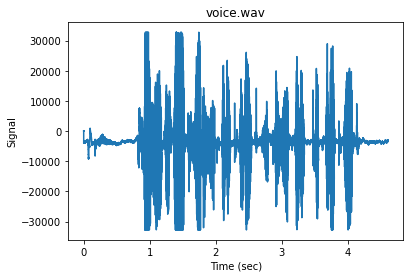

In [22]:
# Just taking a look at the data.
plt.plot(np.arange(len(voicewav[1]))/voicewav[0], voicewav[1])
plt.xlabel('Time (sec)')
plt.ylabel('Signal')
plt.title('voice.wav')

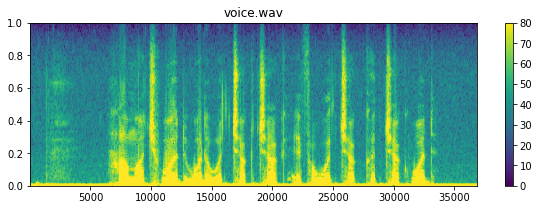

In [23]:
specgram_cbar(voicewav[1], title='voice.wav', clim=(0, 80) )

/srv/conda/envs/notebook/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'voice.wav')

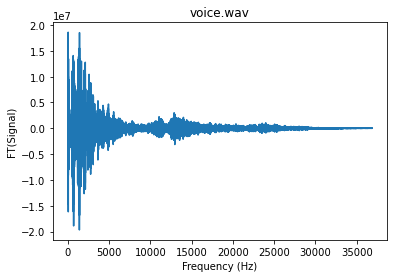

In [24]:
fft = np.fft.rfft(voicewav[1])
plt.plot(fft[1:])
plt.xlabel('Frequency (Hz)')
plt.ylabel('FT(Signal)')
plt.title('voice.wav')

In [25]:
def compress_signal(x, fraction):
    """Compress an input signal by dropping a fraction of its spectrum.
    
    Parameters
    ==========
    x : array
      1-d real array to be compressed
      
    fraction : float
      A number in the [0,1] range indicating which fraction of the spectrum
      of x should be zeroed out (1 means zero out the entire signal).
      
    Returns
    =======
    x_approx : array
      1-d real array reconstructed after having compressed the input.
    """
    # Take FT of the signal.
    fft = np.fft.rfft(x)
    
    # Find where absolute value of the FT is smaller than n% of all the values,
    # and set those values to zero.
    fft_sort = np.sort(np.abs(fft))
    n = len(fft_sort)
    lo = fft_sort[int(n*fraction)]
    idx = np.where(np.abs(fft) < lo)[0]
    fft[idx] = 0

    # Get the compressed signal by taking the inverse FT of the edited FT.
    x_approx = np.fft.irfft(fft)
    
    return x_approx

As a quick visual check (not that this is *not* a formal test of correctness), experiment with a simple random signal by changing the compression ratio and plotting both the signal and the compressed version:

In [26]:
x = np.random.rand(128)

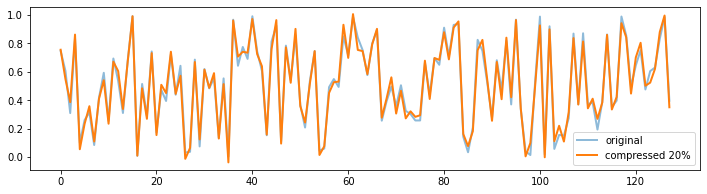

In [27]:
# Small fraction-- looks like original signal. Good!
fraction = 0.2  # play changing this in the 0-1 range

xa = compress_signal(x, fraction)

plt.figure(figsize=(12,3))
plt.plot(x, alpha=0.5, lw=2, label='original')
plt.plot(xa, lw=2, label='compressed {0:.0%}'.format(fraction))
plt.legend();

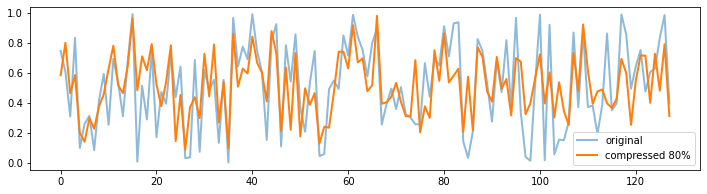

In [28]:
# Large fraction-- looks less like the original signal. Good!
fraction = 0.8  # play changing this in the 0-1 range

xa = compress_signal(x, fraction)

plt.figure(figsize=(12,3))
plt.plot(x, alpha=0.5, lw=2, label='original')
plt.plot(xa, lw=2, label='compressed {0:.0%}'.format(fraction))
plt.legend();

**Problem 3**: Write a function that will compress an audio file by a dropping a fraction of its spectrum, writing the output to a new file.

If the input file is named `a.wav` and the compression fraction is 0.9, the output file should be named `a_comp_0.9.wav`.

*Hints:* 

- look at the `scipy.io` module for routines dealing with files in `wav` format.

- you may need to use the `astype` method of numpy arrays to get the correct data type for `wav` files.

In [29]:
def compress_wav(fname, fraction):
    """Compress an audio signal stored in an input wav file.
    
    The compressed signal is returned as a numpy array and automatically written 
    to disk to a new wav file.
    
    Parameters
    ==========
    fname : string
      Name of the input wav file
      
    fraction : float
      Fraction of input data to keep.
      
    Returns
    =======
    rate : int
      Bit rate of the input signal.

    x : array
      Raw data of the original input signal.
      
    x_approx : array
      Raw data of the compressed signal.
      
    new_fname : string
      Auto-generated filename of the compressed signal.
    """
    # Read in original file.
    rate, x = wavfile.read(fname)
        
    # Compress original file. 
    x_approx = compress_signal(x, fraction)
    
    # New file name
    new_fname = fname.replace('.wav', '_comp_' + str(fraction) + '.wav')
    
    # Write out compressed file.
    wavfile.write(new_fname, rate, x_approx.astype(np.int16))
    
    return rate, x, x_approx, new_fname

In [30]:
# Testing and visualizing a compression of 0.8.
rate08, x08, x_approx08, new_fname08 = compress_wav('Data/voice.wav', 0.8)

In [31]:
Audio('Data/voice_comp_0.8.wav')

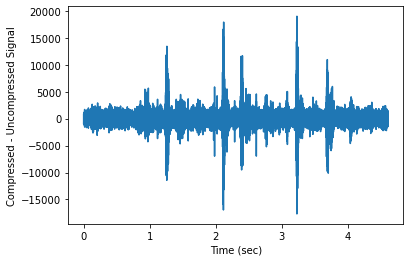

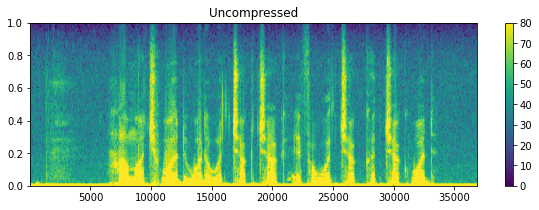

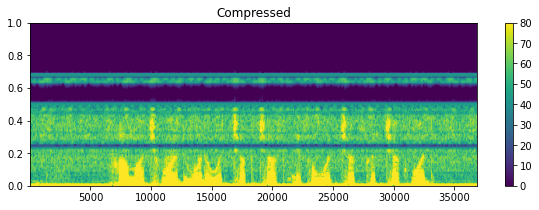

In [32]:
plt.plot(np.arange(len(voicewav[1]))/voicewav[0], x_approx08 - voicewav[1])
plt.xlabel('Time (sec)')
plt.ylabel('Compressed - Uncompressed Signal')
specgram_cbar(x08, title='Uncompressed')
specgram_cbar(x_approx08, title='Compressed')

**Problem 4**: Study the effect of compressing the input file at different ratios: 0.1, 0.5, 0.75, 0.9, 0.95, 0.99.

Using the `OrderedDict` class from the [Python collections module](https://docs.python.org/3/library/collections.html#collections.OrderedDict), store the uncompressed signal as well as the compressed array and filename for each compression ratio.

You will create an `OrderedDict` called `voices`, with:

- keys: compression ratios
- values: pairs of (x, filename) where x is the compressed audio and filename is the name of the compressed file.

In [33]:
from collections import OrderedDict

voices = OrderedDict()
voices[0.1] = (wavfile.read('Data/voice_comp_0.1.wav')[1], 'Data/voice_comp_0.1.wav')
voices[0.5] = (wavfile.read('Data/voice_comp_0.5.wav')[1], 'Data/voice_comp_0.5.wav')
voices[0.75] = (wavfile.read('Data/voice_comp_0.75.wav')[1], 'Data/voice_comp_0.75.wav')
voices[0.9] = (wavfile.read('Data/voice_comp_0.9.wav')[1], 'Data/voice_comp_0.9.wav')
voices[0.95] = (wavfile.read('Data/voice_comp_0.95.wav')[1], 'Data/voice_comp_0.95.wav')
voices[0.99] = (wavfile.read('Data/voice_comp_0.99.wav')[1], 'Data/voice_comp_0.99.wav')               

**Problem 5**: Loop over the `voices` dict, and for each one generate an audio player as well as a spectrogram.  Observe how the spectrogram changes, and listen to each file.  At what ratio do you stop understanding the recording?

**Answer**: Around a ratio of 0.9 to 0.95 is when it starts getting really jumbly. I'm not sure if I would have understood 0.95 compression if I wasn't familiar with this rhyme and/or had heard the original recording prior.

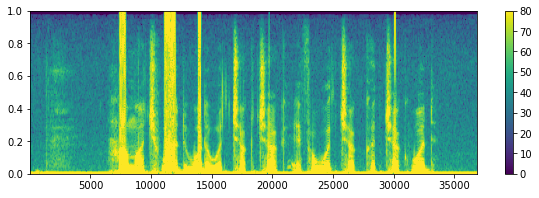

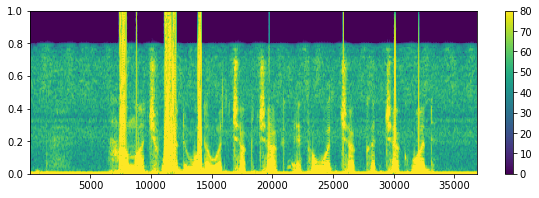

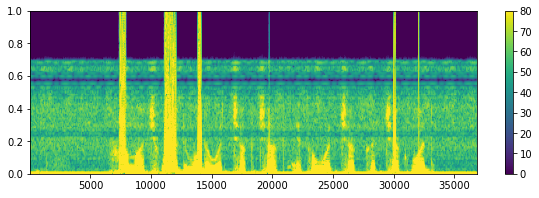

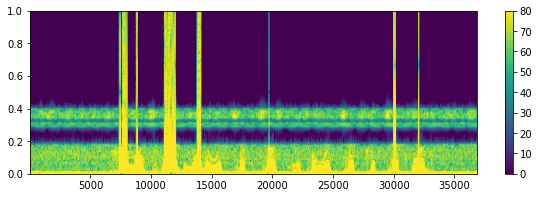

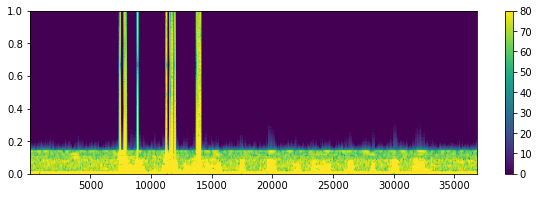

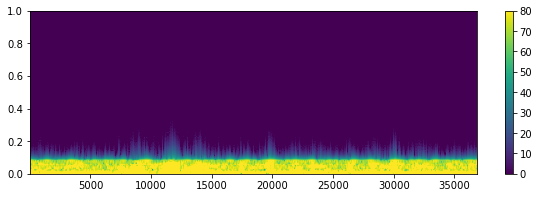

In [34]:
for key in voices:
    caud, fname = voices[key]
    Audio(fname)
    specgram_cbar(caud)

# #3: Armchair Astronomer

Often times, people act as good sensors of the physical universe. We can use Google Trends data to help us determine some fundamental parameters of the Solar System.

**Problem 1**: Using just the CSV file we created in the pandas lecture (`merged_data.csv`) and some frequency analysis tools in `scipy` to determine:

   - the number of days in a year
   - the period of the moon's orbit around the Earth
   
Hint: `from scipy.signal.spectral import lombscargle` (you'll want to normalize your signal so it has a mean of zero.)

In [35]:
# Import packages.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
from scipy.signal.spectral import lombscargle

In [36]:
# Load up data.
data = pd.read_csv('data/merged_data.csv')

# Check out format of table.
data.head()

,Week,tennis,ice cream,full moon
0,2017-01-29,17,11,10
1,2017-02-05,13,11,40
2,2017-02-12,15,12,11
3,2017-02-19,16,13,9
4,2017-02-26,16,12,11


In [37]:
# Change the format of the dates from YYYY-MM-DD 
# to a numerical date for calculation/plotting purposes.
# Specifically Gregorian ordinal format.
dates = np.empty(len(data['Week']))
for dd in np.arange(len(data['Week'])):
    dt = date.fromisoformat(data['Week'][dd]).toordinal()
    dates[dd] = dt

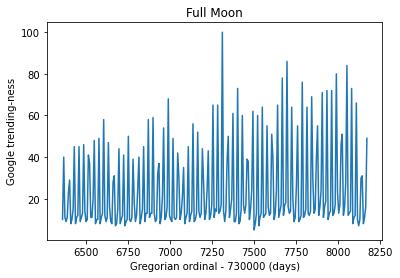

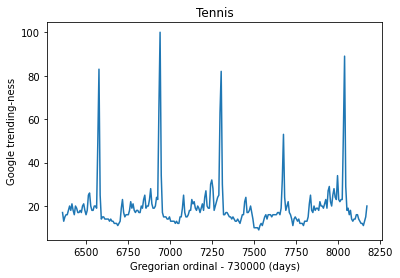

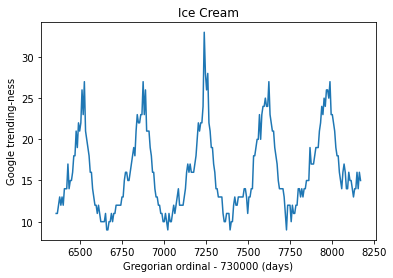

In [38]:
# Look at data. Definitely periodic!
plt.figure(1)
plt.title('Full Moon')
plt.plot(dates - 730000, data['full moon'])
plt.ylabel('Google trending-ness')
plt.xlabel('Gregorian ordinal - 730000 (days)')
plt.show()

plt.figure(2)
plt.title('Tennis')
plt.plot(dates - 730000, data['tennis'])
plt.ylabel('Google trending-ness')
plt.xlabel('Gregorian ordinal - 730000 (days)')
plt.show()

plt.figure(3)
plt.title('Ice Cream')
plt.plot(dates - 730000, data['ice cream'])
plt.ylabel('Google trending-ness')
plt.xlabel('Gregorian ordinal - 730000 (days)')
plt.show()

In [39]:
# For each trend, subtract off the average so the mean of 
# each dataset is 0.
tennis_avg = np.average(data['tennis'])
icecream_avg = np.average(data['ice cream'])
fullmoon_avg = np.average(data['full moon'])

# Sampling frequencies
f = np.arange(0.0001, 1, 0.0005)

tennis_pgram = lombscargle(dates, data['tennis'] - tennis_avg, f)
icecream_pgram = lombscargle(dates, data['ice cream'] - icecream_avg, f)
fullmoon_pgram = lombscargle(dates, data['full moon'] - fullmoon_avg, f)

fullmoon_period_days=29.554023081747822


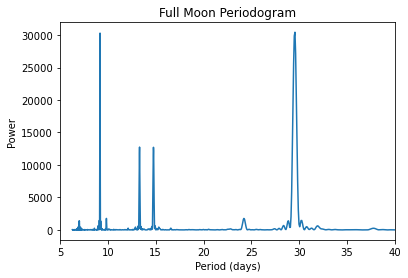

tennis_period_days=367.4377372619641


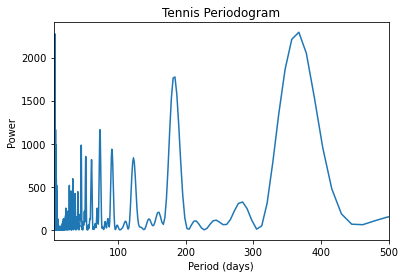

icecream_period_days=367.4377372619641


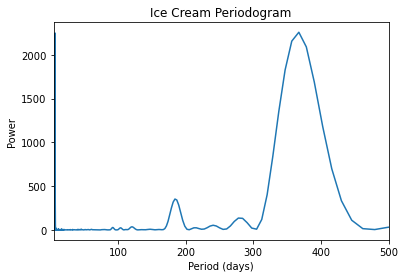

In [40]:
fdx = np.argmax(fullmoon_pgram)
fullmoon_period_days = 2 * np.pi/f[fdx]
print(f"{fullmoon_period_days=}")

plt.figure(1)
plt.plot(2 * np.pi/f, fullmoon_pgram)
plt.xlim(5, 40)
plt.title('Full Moon Periodogram')
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.show()

tdx = np.argmax(tennis_pgram)
tennis_period_days = 2 * np.pi/f[tdx]
print(f"{tennis_period_days=}")

plt.figure(2)
plt.plot(2 * np.pi/f, tennis_pgram)
plt.xlim(5, 500)
plt.title('Tennis Periodogram')
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.show()

idx = np.argmax(icecream_pgram)
icecream_period_days = 2 * np.pi/f[idx]
print(f"{icecream_period_days=}")

plt.figure(3)
plt.plot(2 * np.pi/f, icecream_pgram)
plt.title('Ice Cream Periodogram')
plt.xlim(5, 500)
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.show()

**Answer:** The full moon periodogram peaks every 30 days, so the period of the moon's orbit around the Earth is around 30 days. The ice cream and tennis periodograms peak every 367 days, so a year is around 367 days. (I know it's actually 365.25, not sure where this ~1 day difference is from.) Presumably the full moon searches peak when there's a full moon, and once a year some places give out free ice cream on National Ice Cream Day, and once a year there's a big tennis match (Wimbledon) so for both of those, so those are when those searches peak.


In [41]:
# Just exploring the periodograms more...
# Some of the peaks look to be very similar heights, taking a look at what the highest peaks are.
# Ice cream seems to peak once a year (National Ice Cream Day?), as well as weekly (people buy ice cream on weekends?)
# Tennis is similar to ice cream (Wimbledon and weekends?)
# Moon is once a month, and slightly longer than weekly-- not sure I know about 9 day one.
from scipy.signal import find_peaks
print('Ice cream')
peaks = find_peaks(icecream_pgram, 2000)
print('Peak heights :', icecream_pgram[peaks[0]])
print('Period (days): ', 2 * np.pi/f[peaks[0]])
print('')
print('Tennis')
peaks = find_peaks(tennis_pgram, 2000)
print('Peak heights :', tennis_pgram[peaks[0]])
print('Period (days): ', 2 * np.pi/f[peaks[0]])
print('')
print('Full moon')
peaks = find_peaks(fullmoon_pgram, 30000)
print('Peak heights :', fullmoon_pgram[peaks[0]])
print('Period (days): ', 2 * np.pi/f[peaks[0]])

Ice cream
Peak heights : [2257.32325212 2245.18939072 2245.91538919]
Period (days):  [367.43773726   7.13511845   6.86987241]

Tennis
Peak heights : [2293.52724908 2270.61008376 2271.82892263]
Period (days):  [367.43773726   7.13511845   6.86987241]

Full moon
Peak heights : [30431.38894966 30297.62400582]
Period (days):  [29.55402308  9.17789265]
